In [11]:
import numpy as np

#import Python ot to compare the performance
import ot

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

from src import sinkhorn

from utils.metrics import *
from visualisation.transport_plan_visualisation import *
from dataset_generators.empirical_distributions import *

### Square grid (2D)
---

The grid is defined by the following properties:
- Number of points in each direction $N_i, i = 1, 2$
- Lattice spacings (distance between adjacent nodes) $a_i = 1, 2$

The data is generated by choosing with equal probability a point on the grid.  

1) Let's us show the result of the optimal transport on the small dataset

In [2]:
n = 50

n_x = [100, 100]
a_x = np.array([0.01, 0.01])

x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)

#matrix with the pairwise distances
C = np.array(cdist(x_i, x_f))

#during the generation the actual number of points can be a bit smaller that n
n = x_i.shape[0]

#take the uniform distribution of weights, for simplicity
a, b = np.ones((n,)) / n, np.ones((n,)) / n 

Get the transportation plan via the **Sinkhorn** iteration. 

In [4]:
G = sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b)

Plot the assignment. The dark red background means almost no weight, 
and the blue pixel in position $(i, j)$ means that considerable 
amount is transported from $i$ to $j$. 

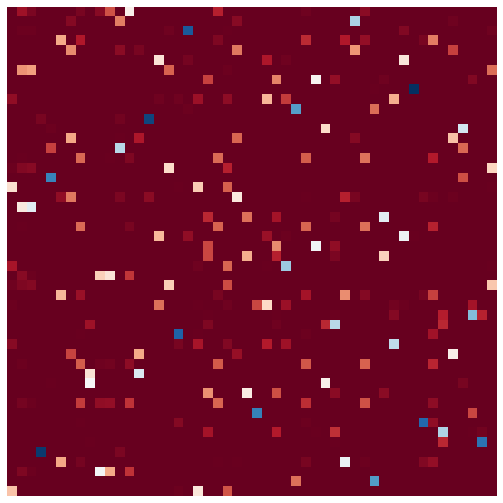

In [7]:
imshow_transportation(G)

The blue points denote the sources, and the red one denote the sinks, the opacity of the line is proportional to 
the amount transfered from the source to destination. 

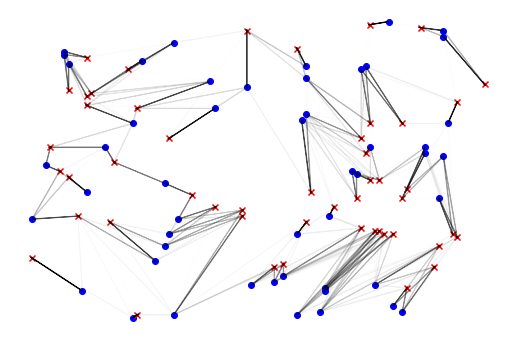

In [5]:
plot_transportation_2d(x_i, x_f, G)

### Performance measurements
---
We are going to compare our package with the Python OT package for dense and sparsified case. 

In [12]:
ns = 2 ** np.arange(7, 13)

t1, t1_err = [], []
t2, t2_err = [], []
t3, t3_err = [], []

for n in ns:
    n_x = [100, 100]
    a_x = np.array([0.01, 0.01])

    x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
    x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
     
    C = np.array(cdist(x_i, x_f))
    n = x_i.shape[0]
    a, b = np.ones((n,)) / n, np.ones((n,)) / n 
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b, make_sparse=False)
    t1.append(t.average)
    t1_err.append(t.stdev)
    
    t = %timeit -o ot.bregman.sinkhorn_knopp(a = a, b = b, M = C, reg = 1e-2)
    t2.append(t.average)
    t2_err.append(t.stdev)
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b, make_sparse=True)
    t3.append(t.average)
    t3_err.append(t.stdev)

88.6 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
153 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.8 ms ± 6.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
359 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
253 ms ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
59 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
369 ms ± 58.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
526 ms ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
139 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.69 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.08 s ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
347 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.34 s ± 648 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.3 s ± 932 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.57 s ± 48.5 ms per loop (mean ± std. dev.

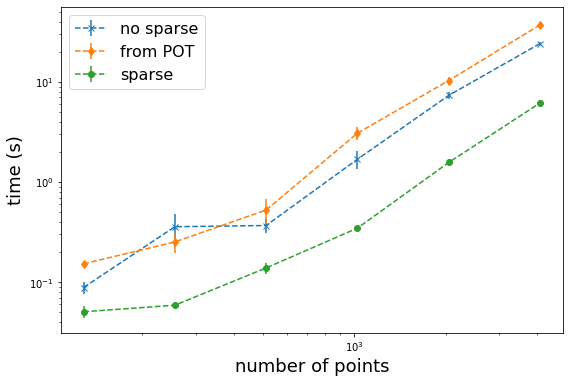

In [19]:
plt.figure(figsize = (9, 6))

plt.errorbar(ns, t1, yerr= t1_err, fmt = 'x--', label = "no sparse")
plt.errorbar(ns, t2, yerr= t2_err, fmt = 'd--', label = "from POT")
plt.errorbar(ns, t3, yerr= t3_err, fmt = 'o--', label = "sparse")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("number of points", fontsize = 18)
plt.ylabel("time (s)", fontsize = 18)

plt.legend(fontsize = 16)

plt.savefig("timing_plots/time_comparison.png")

Overall, the non-sparse version of sinkhorn turned out to be slightly faster than the implementation from `Python OT`, 
and the sparse version provides a gain $5-6$ times in performance. 

In [20]:
ns = 2 ** np.arange(5, 11)

t1, t1_err = [], []
t2, t2_err = [], []
t3, t3_err = [], []

for n in ns:
    n_x = [100, 100]
    a_x = np.array([0.01, 0.01])

    x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
    x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
     
    C = np.array(cdist(x_i, x_f))
    n = x_i.shape[0]
    a, b = np.ones((n,)) / n, np.ones((n,)) / n 
    
    t = %timeit -o sinkhorn.sinkhorn_stabilized(C, reg = 1e-3, a = a, b = b, make_sparse=False)
    t1.append(t.average)
    t1_err.append(t.stdev)
    
    t = %timeit -o ot.bregman.sinkhorn_stabilized(a = a, b = b, M = C, reg = 1e-3)
    t2.append(t.average)
    t2_err.append(t.stdev)
    
    t = %timeit -o sinkhorn.sinkhorn_stabilized(C, reg = 1e-3, a = a, b = b, make_sparse=True)
    t3.append(t.average)
    t3_err.append(t.stdev)

30.1 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.7 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.3 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.2 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
117 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
328 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
494 ms ± 95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
209 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.54 s ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2 s ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
466 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.52 s ± 53.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.17 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.78 s ± 12.2 ms per loop (mean ± std. de

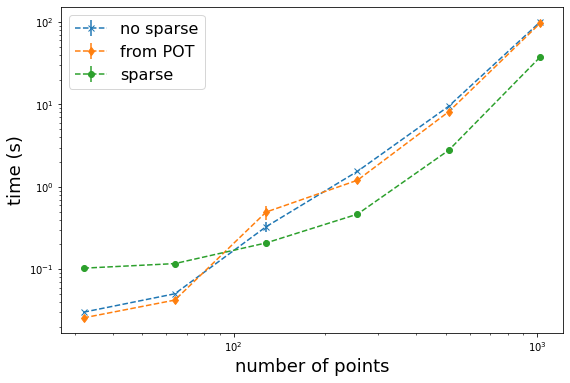

In [21]:
plt.figure(figsize = (9, 6))

plt.errorbar(ns, t1, yerr= t1_err, fmt = 'x--', label = "no sparse")
plt.errorbar(ns, t2, yerr= t2_err, fmt = 'd--', label = "from POT")
plt.errorbar(ns, t3, yerr= t3_err, fmt = 'o--', label = "sparse")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("number of points", fontsize = 18)
plt.ylabel("time (s)", fontsize = 18)

plt.legend(fontsize = 16)

plt.savefig("timing_plots/time_comparison_stabilized.png")

Here we observe, that the our implementation and the POT for dense give comparable performance, but for large enough data the sparse 
implementation performs faster anyway. 

Let us compare the actual distributions

In [47]:
n = 512

n_x = [100, 100]
a_x = np.array([0.01, 0.01])

x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)

C = np.array(cdist(x_i, x_f))
n = x_i.shape[0]
a, b = np.ones((n,)) / n, np.ones((n,)) / n 

In [48]:
G_dense = sinkhorn.sinkhorn_stabilized(C, reg = 1e-2, a = a, b = b, make_sparse=True, sparsification_strategy="keep_n_largest", min_nnz = 20)
G_sparse = sinkhorn.sinkhorn_stabilized(C, reg = 1e-2, a = a, b = b, make_sparse=False)

In [75]:
print(f"The relative difference between the dense and sparse case is : {np.linalg.norm(G_sparse - G_dense) / np.linalg.norm(G_dense) :.2e}")

The relative difference between the dense and sparse case is : 1.85e-02


So the results of the approximation by dense and sparse matrices are approximately the same

### Mixture of gaussians (2D)
---

The dataset is generated from the mixture of $k$ gaussians, defined by:
- Proportions of the distributions $\pi_i$ (probability, that the point will the sampled from $i^{\text{th}}$ gaussian)
- Means of the gaussians $\mu_i, i = 1 \ldots k$
- Covariances of the gaussians $\Sigma_i = 1, 2$ 

In [78]:
n = 50

n_x = [100, 100]
a_x = np.array([0.01, 0.01])

x_i = make_blobs(n, 
                 proportions=[0.2, 0.5, 0.3],
                 means = [
                      np.array([-5, 0]), 
                      np.array([5, 0]), 
                      np.array([0, 5])
                 ],
                 covariances=[
                      np.array([[1, 0], [0, 1]]),
                      np.array([[0.5, 0], [0, 4]]),
                      np.array([[1, 0], [0, 1]]),
                 ])

x_f = make_blobs(n, 
                 proportions=[0.2, 0.5, 0.3],
                 means = [
                      np.array([8, 0]),
                      np.array([0, 0]), 
                      np.array([-2, 2])
                 ],
                 covariances=[
                      np.array([[1, 0], [0, 2]]),
                      np.array([[4, 0], [0, 4]]),
                      np.array([[2, 0], [0, 1]]),
                 ])

#matrix with the pairwise distances
C = np.array(cdist(x_i, x_f))

#during the generation the actual number of points can be a bit smaller that n
n = x_i.shape[0]

#take the uniform distribution of weights, for simplicity
a, b = np.ones((n,)) / n, np.ones((n,)) / n 

In [79]:
G = sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b)

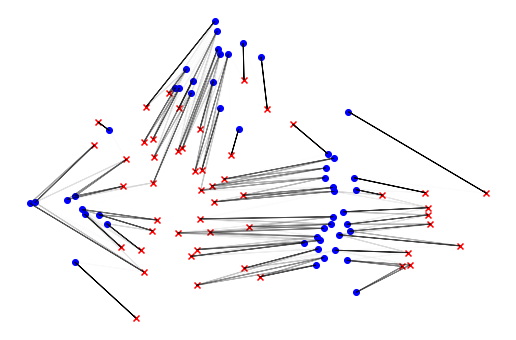

In [80]:
plot_transportation_2d(x_i, x_f, G)

### Performance measurements
---

In [91]:
ns = 2 ** np.arange(7, 13)

t1, t1_err = [], []
t2, t2_err = [], []

for idx, n in enumerate(ns):    
    x_i = make_blobs(n, 
                 proportions=[0.2, 0.5, 0.3],
                 means = [
                      np.array([-5, 0]), 
                      np.array([5, 0]), 
                      np.array([0, 5])
                 ],
                 covariances=[
                      np.array([[1, 0], [0, 1]]),
                      np.array([[0.5, 0], [0, 4]]),
                      np.array([[1, 0], [0, 1]]),
                 ])

    x_f = make_blobs(n, 
                     proportions=[0.2, 0.5, 0.3],
                     means = [
                          np.array([8, 0]),
                          np.array([0, 0]), 
                          np.array([-2, 2])
                     ],
                     covariances=[
                          np.array([[1, 0], [0, 2]]),
                          np.array([[4, 0], [0, 4]]),
                          np.array([[2, 0], [0, 1]]),
                     ])
    
    C = np.array(cdist(x_i, x_f))

    n = x_i.shape[0]

    a, b = np.ones((n,)) / n, np.ones((n,)) / n 
    
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b, make_sparse=False)
    t1.append(t.average)
    t1_err.append(t.stdev)
    
    min_nnz = 10 * (idx + 2)
    t = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b, make_sparse=True, sparsification_strategy="keep_n_largest", min_nnz=min_nnz)
    t2.append(t.average)
    t2_err.append(t.stdev)

152 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.8 ms ± 932 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
233 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.3 ms ± 692 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
569 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
130 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.99 s ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
143 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.41 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
350 ms ± 8.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.4 s ± 2.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


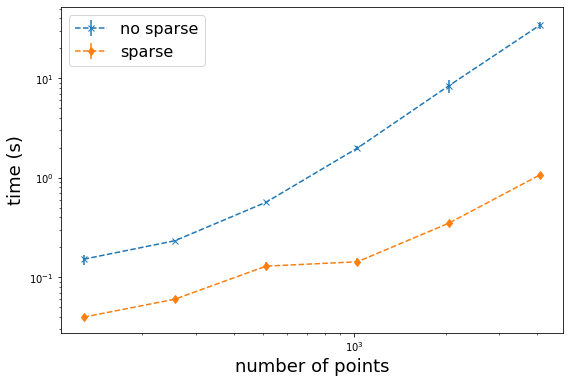

In [92]:
plt.figure(figsize = (9, 6))

plt.errorbar(ns, t1, yerr= t1_err, fmt = 'x--', label = "no sparse")
plt.errorbar(ns, t2, yerr= t2_err, fmt = 'd--', label = "sparse")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("number of points", fontsize = 18)
plt.ylabel("time (s)", fontsize = 18)

plt.legend(fontsize = 16)

plt.savefig("timing_plots/time_comparison_mixture_of_gaussian.png")

As one can see, kernel truncation leads to the performance gain. However the truncation has to be adjusted carefully 
in order to avoid numerical errors. 